# Figure 3: Dependence of Exobase Solutions on κ for RKD Electrons

This notebook reproduces **Figure 3** from the paper  
**"Kinetic-based macro-modeling of the solar wind at large heliocentric distances: Kappa electrons at the exobase"**  
(submitted to *JGR–Space Physics*).

<>:138: SyntaxWarning: invalid escape sequence '\k'
<>:144: SyntaxWarning: invalid escape sequence '\P'
<>:148: SyntaxWarning: invalid escape sequence '\k'
<>:161: SyntaxWarning: invalid escape sequence '\k'
<>:138: SyntaxWarning: invalid escape sequence '\k'
<>:144: SyntaxWarning: invalid escape sequence '\P'
<>:148: SyntaxWarning: invalid escape sequence '\k'
<>:161: SyntaxWarning: invalid escape sequence '\k'
/var/folders/yf/bhm7115535n8zj8mfplb9pfm0000gp/T/ipykernel_28257/1098983909.py:138: SyntaxWarning: invalid escape sequence '\k'
  ax1.set_xlabel('$\kappa$')
/var/folders/yf/bhm7115535n8zj8mfplb9pfm0000gp/T/ipykernel_28257/1098983909.py:144: SyntaxWarning: invalid escape sequence '\P'
  ax2.set_ylabel('$\Phi_E(r_0)$ [V]')
/var/folders/yf/bhm7115535n8zj8mfplb9pfm0000gp/T/ipykernel_28257/1098983909.py:148: SyntaxWarning: invalid escape sequence '\k'
  ax2.set_xlabel('$\kappa$')
/var/folders/yf/bhm7115535n8zj8mfplb9pfm0000gp/T/ipykernel_28257/1098983909.py:161: SyntaxWarning: inval

alpha=0.02, kappa=0.1, y=138829.50405947326, Phi=1196340.1030988179 V, V_SW=15136949.54668017 m/s
alpha=0.02, kappa=0.5, y=18757.376813558567, Phi=808192.8356303449 V, V_SW=12440549.962879272 m/s
alpha=0.02, kappa=1.5, y=360.86965054971955, Phi=46646.01064471208 V, V_SW=2978705.093913196 m/s
alpha=0.02, kappa=2, y=40.738295423219576, Phi=7021.109363872136 V, V_SW=1132023.7113079322 m/s
alpha=0.02, kappa=3, y=6.278934605532038, Phi=1623.2301608125697 V, V_SW=497363.0451890551 m/s
alpha=0.02, kappa=5, y=1.8081058064673554, Phi=779.0525153774488 V, V_SW=292652.11864300695 m/s
alpha=0.02, kappa=10, y=0.60577142804911, Phi=522.0134276184781 V, V_SW=190794.58034439367 m/s
alpha=0.02, kappa=20, y=0.25608606806632994, Phi=441.3557984639919 V, V_SW=144742.7112540586 m/s
alpha=0.1, kappa=0.1, y=4044.8070301291477, Phi=34855.45015969056 V, V_SW=2571748.0058385935 m/s
alpha=0.1, kappa=0.5, y=564.866258836565, Phi=24338.2040046792 V, V_SW=2144534.654576683 m/s
alpha=0.1, kappa=1.5, y=49.32775244338

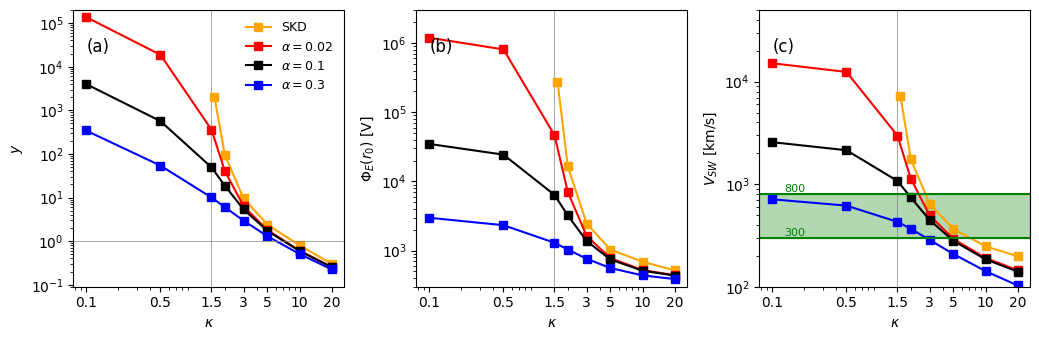

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, constants
import mpmath as mp
from matplotlib.ticker import FormatStrFormatter

# Set mpmath precision
mp.mp.dps = 30  

# --- Physical constants ---
kB = constants.Boltzmann
m_e = constants.m_e
m_p = constants.m_p
e_charge = constants.e
G = 6.674e-11
R_sun = 6.957e8
M_sun = 1.989e30

# --- Temperatures (K) ---
T_e = 1e6
T_p = 2e6

# --- Thermal velocities ---
w_e2 = 2 * kB * T_e / m_e
w_p2 = 2 * kB * T_p / m_p
w_e = np.sqrt(w_e2)
w_p = np.sqrt(w_p2)

# --- Gravitational potential at solar surface ---
Phi_G = m_p * G * M_sun / (6 * R_sun)

# --- Compute terminal velocity ---
def compute_Vsw(phi):
    energy = e_charge * phi - Phi_G
    return np.sqrt(2 * energy / m_p) if energy > 0 else np.nan

# --- Hypergeometric U function using mpmath for high precision ---
def hyperu_mpmath(a, b, z):
    """Evaluate U(a, b, z) using mpmath for high precision"""
    try:
        return float(mp.hyperu(mp.mpf(a), mp.mpf(b), mp.mpf(z)))
    except:
        return np.nan

# --- Solve for y given kappa ---
def solve_for_y(kappa, alpha, verbose=False):
    beta = alpha**2 * kappa

    def equation(y):
        U1 = hyperu_mpmath(1.5, 1.5 - kappa, beta)
        U2 = hyperu_mpmath(kappa, kappa, beta * (1 + y))
        U3 = hyperu_mpmath(1 + kappa, 1 + kappa, beta * (1 + y))

        lhs = w_p / w_e
        rhs = (np.sqrt(kappa) * np.exp(-beta * y) / (2 * U1)) * (
            beta**(kappa - 1) * U2 - beta**kappa * U3
        )
        return lhs - rhs

    # Search for root
    y_min, y_max = 1e-2, 1e6
    y_grid = np.logspace(np.log10(y_min), np.log10(y_max), 500)
    f_vals = [equation(y) for y in y_grid]

    for i in range(len(y_grid) - 1):
        if np.isfinite(f_vals[i]) and np.isfinite(f_vals[i+1]):
            if f_vals[i] * f_vals[i+1] < 0:
                try:
                    sol = optimize.root_scalar(
                        equation, bracket=[y_grid[i], y_grid[i+1]], method="brentq"
                    )
                    if sol.converged:
                        return sol.root
                except:
                    continue
    if verbose:
        print(f"[WARN] No root found for kappa={kappa}, beta={beta:.3e}")
    return np.nan

# --- Parameters ---
alpha_values = [0.02, 0.1, 0.3]
kappa_values = [0.1, 0.5, 1.5, 2, 3, 5, 10, 20]

# --- Store results for each alpha ---
results = {}
for alpha in alpha_values:
    Y_values, Phi_values, Vsw_values, Z_values = [], [], [], []
    for kappa in kappa_values:
        y = solve_for_y(kappa, alpha, verbose=True)
        beta = alpha**2 * kappa
        Phi = m_e * w_e2 * kappa * y / (2 * e_charge) if np.isfinite(y) else np.nan
        Vsw = compute_Vsw(Phi) if np.isfinite(Phi) else np.nan
        Z=beta*(1+y)

        Y_values.append(y)
        Phi_values.append(Phi)
        Vsw_values.append(Vsw)
        Z_values.append(Z)
        
        print(f"alpha={alpha}, kappa={kappa}, y={y}, Phi={Phi} V, V_SW={Vsw} m/s")

    results[alpha] = {
        "Y": np.array(Y_values),
        "Phi": np.array(Phi_values),
        "Vsw": np.array(Vsw_values),
        "Z": np.array(Z_values)
    }

# --- Setup plots ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10.5, 3.5), sharex=True)

colors = {0.02: "red", 0.1: "black", 0.3: "b"}  # assign colors
ax1.axvline(1.5, color='grey', lw=0.5)
ax2.axvline(1.5, color='grey', lw=0.5)
ax3.axvline(1.5, color='grey', lw=0.5)

#########################################################################################################
kappa_values_SKD=np.asarray([1.6,2,3,5,10,20])
Y0_values_SKD=np.asarray([2011.4, 95.3, 9.5, 2.4, 0.8, 0.3])
V_SW_values_SKD=np.asarray([7284586.6, 1755717.4, 639733.4, 367213.5, 247423.2, 198433.0])
Phi_values_SKD = m_e*w_e2*kappa_values_SKD/(2*e_charge)*Y0_values_SKD

ax1.plot(kappa_values_SKD, Y0_values_SKD, color='orange',ls='-',marker='s', label='SKD')
ax2.plot(kappa_values_SKD, Phi_values_SKD, color='orange',ls='-',marker='s')
ax3.plot(kappa_values_SKD, np.asarray(V_SW_values_SKD)/1e3, color='orange',ls='-',marker='s', label='SKD')

# (a) y vs kappa
for alpha in alpha_values:
    ax1.plot(kappa_values, results[alpha]["Y"], marker='s', ls='-',
             color=colors[alpha], label=f"$\\alpha={alpha}$")
ax1.set_yscale('log')
ax1.set_ylabel('$y$')
ax1.axhline(1, ls='-', color='grey', lw=0.5)

ax1.text(0.05, 0.85, "(a)", transform=ax1.transAxes, fontsize=12)
ax1.set_ylim(0.09,2e5)
ax1.legend(fontsize=9, frameon=False)
ax1.set_xlabel('$\kappa$')

# (b) Phi vs kappa
for alpha in alpha_values:
    ax2.plot(kappa_values, results[alpha]["Phi"], marker='s', ls='-',
             color=colors[alpha], label=f"$\\alpha={alpha}$")
ax2.set_ylabel('$\Phi_E(r_0)$ [V]')
ax2.set_yscale('log')
ax2.text(0.05, 0.85, "(b)", transform=ax2.transAxes, fontsize=12)
ax2.set_ylim(300,3e6)
ax2.set_xlabel('$\kappa$')

# (c) Vsw vs kappa
for alpha in alpha_values:
    ax3.loglog(kappa_values, results[alpha]["Vsw"]/1e3, marker='s', ls='-',
               color=colors[alpha], label=f"$\\alpha={alpha}$")

ax3.set_ylabel('$V_{SW}$ [km/s]')
ax3.axhspan(300, 800, color='g', alpha=0.3, label='Observations')
ax3.axhline(300, color='g'); ax3.text(0.13, 300, '300', fontsize=8, color='g', va='bottom')
ax3.axhline(800, color='g'); ax3.text(0.13, 800, '800', fontsize=8, color='g', va='bottom')
ax3.text(0.05, 0.85, "(c)", transform=ax3.transAxes, fontsize=12)
ax3.set_ylim(1e2,5e4)
ax3.set_xlabel('$\kappa$')

ax3.set_xticks([0.1,0.5, 1.5,3,5,10,20])
ax3.set_xticklabels([0.1,0.5, 1.5,3,5,10,20])

plt.tight_layout()
plt.savefig('Figure_3.pdf', bbox_inches='tight')
plt.show()